# Introduzione

L'obiettivo è quello di analizzare il dataset sui funghi, e testare diversi classificatori per trovare il migliore nel classificare nuovi funghi come commestibili o velenosi. Il documento è composto come segue:

- Data Exploration
    - Analisi classi dataset
    - Feature Selection
    - Rimozione righe malformate
- Test Classificatori
    - Naive Bayes
    - Random Forest
    - ...
    - ...

Import delle librerie necessarie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
#altri import futuri

Caricamento del dataset

In [2]:
dataset = pd.read_csv("dataset/secondary_data.csv", sep=";")
print("Dimension:", dataset.shape)
dataset.head()

Dimension: (61069, 21)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


# Data Exploration

## Class Balancing

Siamo interessati a classificare i funghi come velenosi o meno, per questo motivo identifichiamo le due classi di interesse a partire dalla colonna "class" del dataset. Vogliamo vedere quanto sono bilanciate le classi del dataset

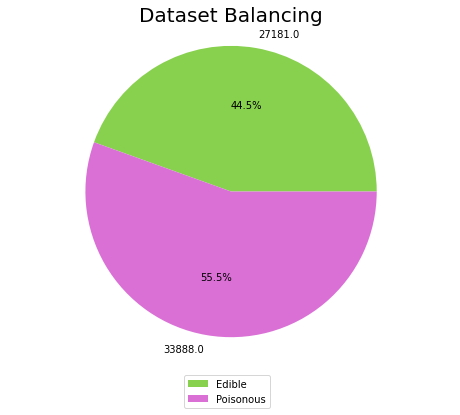

In [3]:
classes = [{"Commestibili": (dataset["class"] == "e").sum(), "Velenosi": (dataset["class"] == "p").sum()}]
total  = pd.DataFrame(classes)
total_e = float(total["Commestibili"])
total_p = float(total["Velenosi"])
mushrooms = [total_e, total_p]
mushrooms_labels = 'Edible','Poisonous'
fig, ax = plt.subplots(figsize = (8,6))
plt.pie(mushrooms,labels=mushrooms,autopct='%1.1f%%',colors = ['#88d14f', '#DA70D6'])
plt.title('Dataset Balancing', loc = "center", fontsize="20")
plt.axis('equal')
plt.legend(mushrooms_labels,bbox_to_anchor=(0.6, -0.05, 0, 0))
fig.set_facecolor('white')
plt.show()

Vediamo che ci sono in percetuale il 10% in più di funghi velenosi, e questo può portare il classificatore a tendere nel classificare funghi come velenosi (falso positivo). Questo errore è meno grave del falso negativo (perche se ti dico che un fungo è velenoso comunque non lo mangi, il contrario invece è velenoso ti dico di no e muori). 

Possiamo pensare di ribilanciare le classi tramite oversampling o undersampling, oppure ancora meglio con SMOTE.

Rivalutare magari il class balancing dopo rimozione delle righe con valori nulli.

## Visualizzazione campi non nulli

Visualizzazione campi non nulli per ogni colonna/feature del dataset. Questo ci serve per vedere eventuali colonne che possono poi essere rimosse

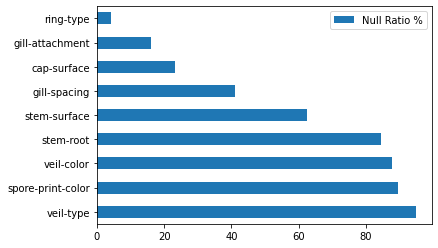

['veil-type', 'spore-print-color', 'veil-color', 'stem-root', 'stem-surface']

In [4]:
def plot_nas(dataset: pd.DataFrame, threshold, use_treshold):
    to_delete = []
    if dataset.isnull().sum().sum() != 0:
        na_dataset = (dataset.isnull().sum() / len(dataset)) * 100
        na_dataset = na_dataset.drop(na_dataset[na_dataset == 0].index).sort_values(ascending=False)
        to_delete = na_dataset[na_dataset > threshold]

        missing_data = pd.DataFrame({'Null Ratio %' :na_dataset})
        missing_data.plot(kind = "barh")
        plt.rcParams['figure.figsize'] = (8,4)

        if use_treshold:
            plt.axvline(x=50, color='red')
            plt.text(45,-1,'thr = 50', color = 'red')
        plt.show()
        
    else:
        print('No NAs found')
    return to_delete.index.tolist()
        

plot_nas(dataset,50,False)

## Feature Visualization

Visualizziamo il numero di classi per ogni feature in modo da visualizzare possibili colonne da rimuovere perche con valori costanti o quasi.

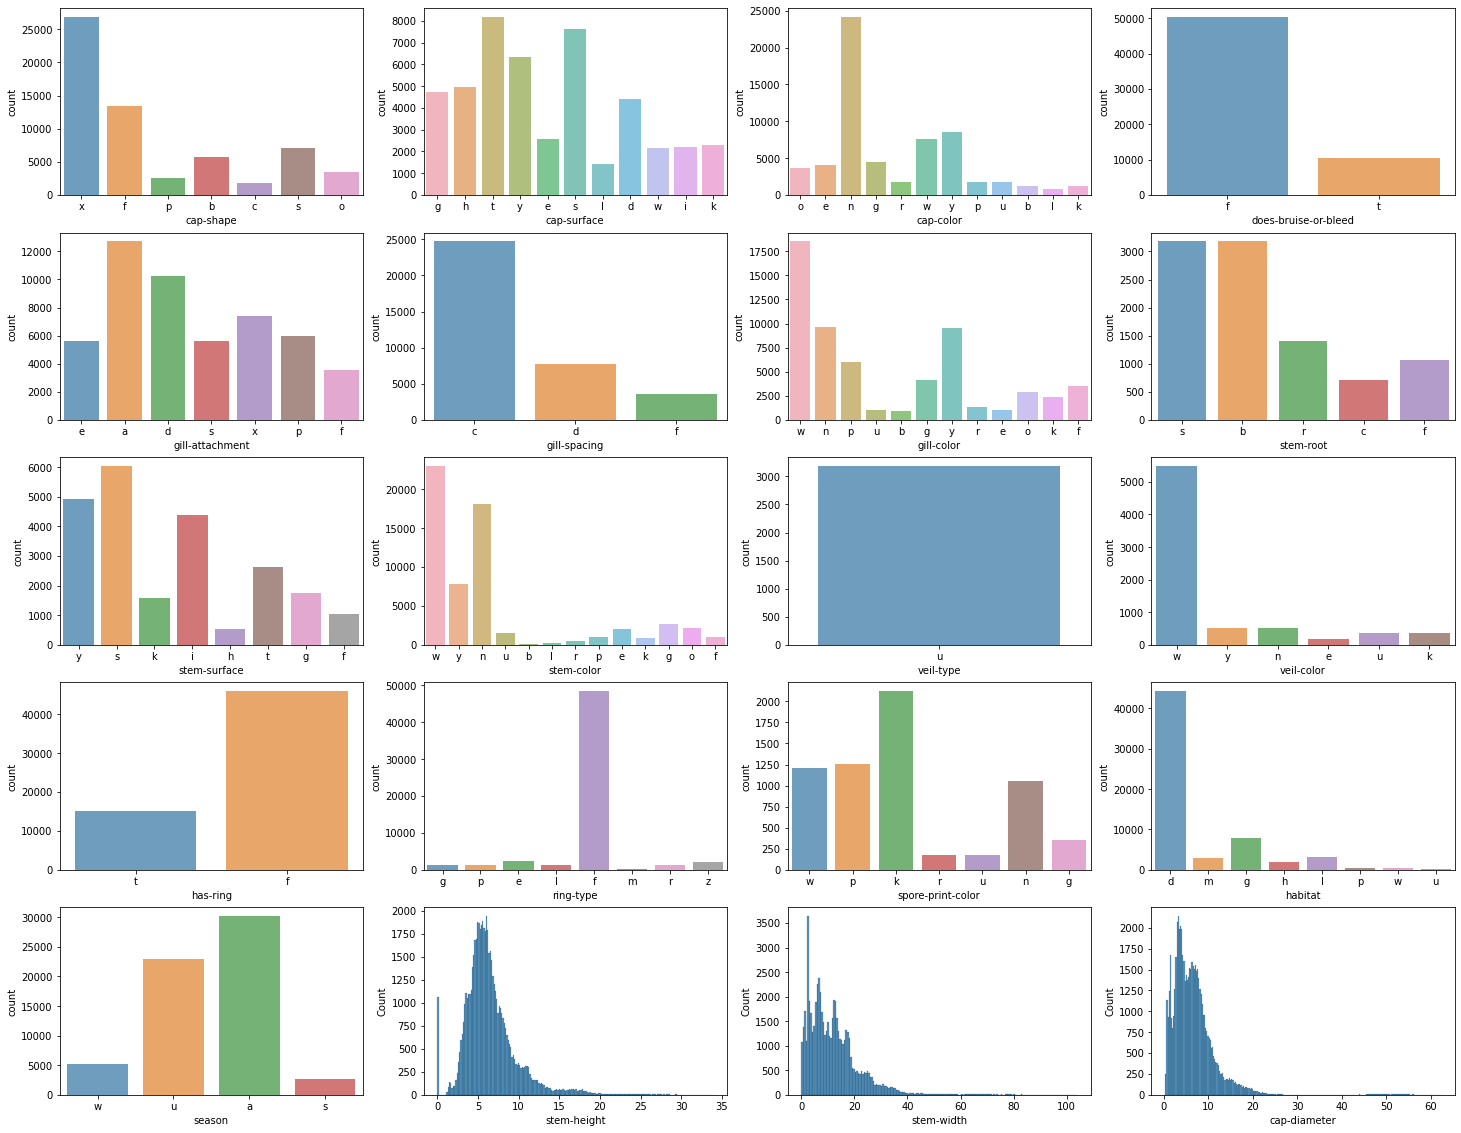

In [5]:
categ = [ 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
conti = ['stem-height', 'stem-width', 'cap-diameter']
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']

fig = plt.figure(figsize=(25,20))
for i in range(0, len(categ)):
    fig.add_subplot(5,4,i+1)
    sns.countplot(x=categ[i], data=dataset, alpha=.7) 

for col in conti:
    fig.add_subplot(5,4,i+2)
    i+=1
    sns.histplot(dataset[col].dropna(), kde_kws={"lw": 2, "color":colors[8]})

Analizzando la distribuzione delle varie features è evidente che la feature ```veil-type``` possa essere rimossa dall'insieme delle features. Questo perché presenta soltanto 3177 valori non nulli, e di valore costante ```u```.

## Conversione Features e Mapping

Conversione delle features categoriche in nominali, si modifica prima il tipo di dato dei valori delle features da ```object``` in ```category``` per poi procedere con l'effettiva trasformazione dei valori categorici.

Si trasformano i valori categorici in numerici (int64) e si salva il dizionario che mantiene il mapping per un eventuale utilizzo futuro.

In [6]:
class LabelEncoderByCol(BaseEstimator, TransformerMixin):
    def __init__(self,col):
        self.col = col
        self.encoders = {}
        self.mapping = []
        for el in self.col:
            self.encoders[el] = LabelEncoder()
            
    def fit(self,x,y=None):
        x[self.col] = x[self.col].fillna('NaN')
        for el in self.col:
            a = x[el][x[el]!='NaN']
            self.encoders[el].fit(a)
        return self

    def transform(self,x,y=None):
        x[self.col] = x[self.col].fillna('NaN')
        for el in self.col:
            if (x[el].dtype == "object") :
                a = x[el][x[el]!='NaN']
                b = x[el].to_numpy()
                b[b!='NaN'] = self.encoders[el].transform(a)
                x[el]=b
                mapping_dict = {index : label for index , label in enumerate(self.encoders[el].classes_)}
                self.mapping.append(mapping_dict)
        return x

In [7]:
encoder = LabelEncoderByCol(dataset.columns)
encoder.fit(dataset)
mapped_dataset = encoder.transform(dataset)

Completiamo trasformando il tipo di dato associato alle features categoriche da ```object``` in ```Int64```, oggetto che accetta valori interi nulli.

In [8]:
for el in mapped_dataset.columns:
    if (mapped_dataset[el].dtype == "object"):
        mapped_dataset[el] = np.floor(pd.to_numeric(mapped_dataset[el], errors='coerce')).astype('float64')

Vediamo che abbiamo mappato le nostre variabili categoriche in variabili ordinali. I valori nulli sono stati mantenuti <NaN> per una successiva fase di imputazione. 

In [9]:
mapped_dataset.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,1.0,15.26,6.0,2.0,6.0,0.0,2.0,NaN,10.0,16.95,...,4.0,7.0,11.0,0.0,4.0,1.0,2.0,NaN,0.0,3.0
1,1.0,16.60,6.0,2.0,6.0,0.0,2.0,NaN,10.0,17.99,...,4.0,7.0,11.0,0.0,4.0,1.0,2.0,NaN,0.0,2.0
2,1.0,14.07,6.0,2.0,6.0,0.0,2.0,NaN,10.0,17.80,...,4.0,7.0,11.0,0.0,4.0,1.0,2.0,NaN,0.0,3.0
3,1.0,14.17,2.0,3.0,1.0,0.0,2.0,NaN,10.0,15.77,...,4.0,7.0,11.0,0.0,4.0,1.0,5.0,NaN,0.0,3.0
4,1.0,14.64,6.0,3.0,6.0,0.0,2.0,NaN,10.0,16.53,...,4.0,7.0,11.0,0.0,4.0,1.0,5.0,NaN,0.0,3.0


## Feature Correlation

Vediamo il grado di correlazione reciproco tra le varie feature, compresa la correlazione di ogni feature con il target. In generale vogliamo che una feature sia altamente correlata con il target (quindi che il suo valore sia importante per discriminare se il fungo è positivo o negativo). Una correlazione alta è sia positiva (aumento del valore di uno aumenta il valore dell'altro) che negativa (aumento del valore di uno diminuisce il valore dell'altro). Una correlazione vicina allo zero implica che le variabili sono indipendenti tra loro.

In [10]:
mapped_dataset.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,1.0,15.26,6.0,2.0,6.0,0.0,2.0,NaN,10.0,16.95,...,4.0,7.0,11.0,0.0,4.0,1.0,2.0,NaN,0.0,3.0
1,1.0,16.60,6.0,2.0,6.0,0.0,2.0,NaN,10.0,17.99,...,4.0,7.0,11.0,0.0,4.0,1.0,2.0,NaN,0.0,2.0
2,1.0,14.07,6.0,2.0,6.0,0.0,2.0,NaN,10.0,17.80,...,4.0,7.0,11.0,0.0,4.0,1.0,2.0,NaN,0.0,3.0
3,1.0,14.17,2.0,3.0,1.0,0.0,2.0,NaN,10.0,15.77,...,4.0,7.0,11.0,0.0,4.0,1.0,5.0,NaN,0.0,3.0
4,1.0,14.64,6.0,3.0,6.0,0.0,2.0,NaN,10.0,16.53,...,4.0,7.0,11.0,0.0,4.0,1.0,5.0,NaN,0.0,3.0


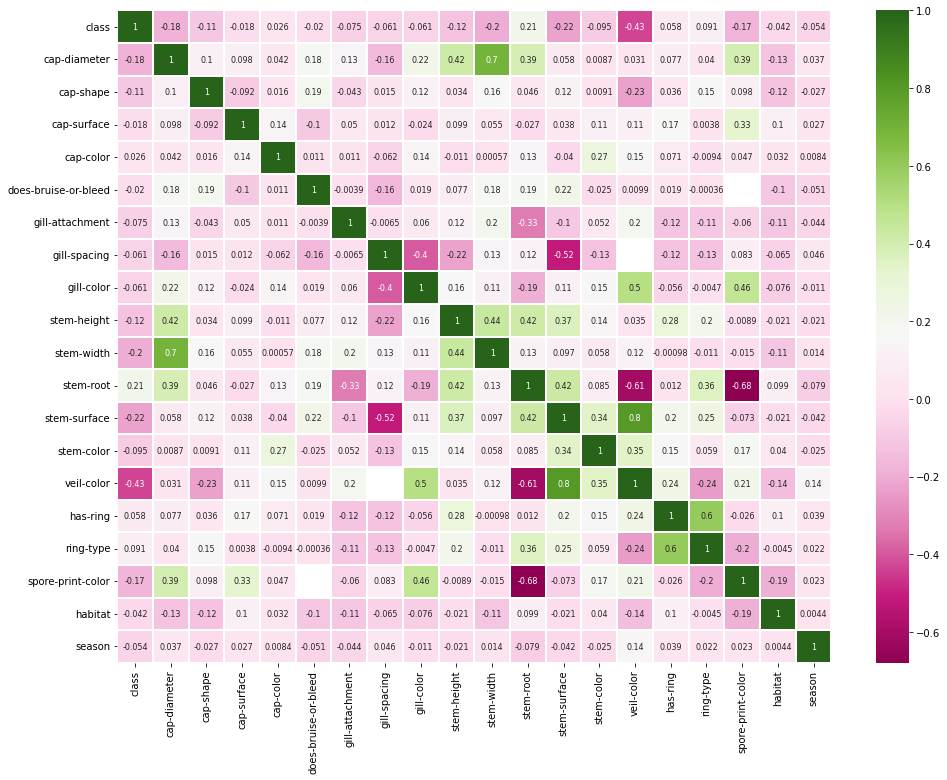

In [11]:
plt.figure(figsize=(16,12))
corr_df = mapped_dataset.drop(columns='veil-type')
correlation_matrix = corr_df.corr()
sns.heatmap(correlation_matrix, linewidths=.1, cmap="PiYG", annot=True, annot_kws={"size": 8}, mask=correlation_matrix.isnull())
plt.yticks(rotation=0)
plt.show()

# Training Set Cleaning

Andiamo a splittare il dataset in training e testing set, per poi andare a seguire diverse operazioni di pulizia delle features sul solo training set.

## Training e Testing Set

Definiamo training e testing set rimuovendo con una estrazione random il 20% delle righe dal dataset originale

In [12]:
target = mapped_dataset['class']
training_X, testing_X, training_Y, testing_Y = train_test_split(mapped_dataset.drop(columns = 'class'), target, test_size = 0.2, random_state=0)
training_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48855 entries, 21214 to 2732
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          48855 non-null  float64
 1   cap-shape             48855 non-null  float64
 2   cap-surface           37554 non-null  float64
 3   cap-color             48855 non-null  float64
 4   does-bruise-or-bleed  48855 non-null  float64
 5   gill-attachment       40947 non-null  float64
 6   gill-spacing          28827 non-null  float64
 7   gill-color            48855 non-null  float64
 8   stem-height           48855 non-null  float64
 9   stem-width            48855 non-null  float64
 10  stem-root             7620 non-null   float64
 11  stem-surface          18230 non-null  float64
 12  stem-color            48855 non-null  float64
 13  veil-type             2548 non-null   float64
 14  veil-color            5959 non-null   float64
 15  has-ring        

# Classificazione

## Decision Tree Classifier

Alleniamo il modello

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(training_X.fillna(50), training_Y)

DecisionTreeClassifier()

Visualizziamo l'albero di decisione

In [14]:
from sklearn.tree import export_graphviz
import graphviz

#Path may vary according to your Graphviz location
dot_data = export_graphviz(dt, out_file=None, 
 feature_names=training_X.columns, 
 filled=True, rounded=True, 
 special_characters=True)

graph = graphviz.Source(dot_data)
#graph.view()

Misuriamo le prestazioni

In [17]:
og_testing = testing_X

#testing_X = testing_X.fillna(-1).drop(columns = ['veil-type', 'veil-color', 'has-ring', 'stem-root', 'stem-surface', 'does-bruise-or-bleed'])
y_pred_dt = dt.predict(testing_X.fillna(50))
print("Decision Tree Classifier report: \n\n", classification_report(testing_Y, y_pred_dt))
print("Test Accuracy: {}%".format(round(dt.score(testing_X.fillna(50), testing_Y.fillna(50))*100, 2)))

Decision Tree Classifier report: 

               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      5302
         1.0       1.00      1.00      1.00      6912

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

Test Accuracy: 99.66%


Abbiamo una ottima accuracy del 92.94%. Adesso andiamo a vedere la matrice di confusione per capire dove sbaglia il classificatore

In [ ]:
cm = confusion_matrix(testing_Y, y_pred_dt)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Reds", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Logistic Regression Classifier')
#plt.savefig("lrcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

Vediamo che la maggior parte dei dati sono classificati correttamente. Gli errori sono 335 falsi positivi (predetti velenosi ma in realtà commestibili) che sono errori comunque accettabili nel senso che comunque non mangerai quel fungo. Invece i 527 errori Falsi negativi sono molto più gravi perché viene classificato come commestibile un fungo in realtà velenoso.

//TODO valutare cost sensitive classifier

In [ ]:
dt_balanced = DecisionTreeClassifier(class_weight='balanced')
dt_balanced.fit(training_X, training_Y.astype("int64"))
y_pred_bal = dt_balanced.predict(testing_X)
print("Decision Tree Classifier report: \n\n", classification_report(testing_Y, y_pred_dt))
print("Test Accuracy: {}%".format(round(dt.score(testing_X, testing_Y)*100, 2)))

In [ ]:
cm = confusion_matrix(testing_Y, y_pred_bal)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Reds", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Logistic Regression Classifier with Balancing')
plt.show()

Proviamo invece sul dataset originale senza imputazione e feature selection

In [ ]:
no_clean_df = mapped_dataset.fillna(-1)
target = mapped_dataset['class']
train, testing, trainY, testY = train_test_split(no_clean_df.drop(columns = 'class'), target, test_size = 0.2, random_state=0)

dt_nc = RandomForestClassifier()
dt_nc.fit(train, trainY.astype("int64"))

train = train.astype("float64")
testY = testY.astype("float64")

y_pred_nc = dt_nc.predict(testing)
print("Decision Tree Classifier report: \n\n", classification_report(testY, y_pred_nc))
print("Test Accuracy: {}%".format(round(dt_nc.score(testing, testY)*100, 2)))


In [ ]:
cm = confusion_matrix(testY, y_pred_nc)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Reds", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Logistic Regression Classifier with Balancing')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr = LogisticRegression(solver="liblinear")           # liblinear dalla documentazione dice che è ottimo per 
lr.fit(train, trainY.astype("float64"))

lr_targets_predicted = lr.predict(testing.astype("float64"))

print("Logistic Regression Classifier report: \n\n", classification_report(testY, lr_targets_predicted))

cm = confusion_matrix(testY, lr_targets_predicted)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Reds", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTED LABEL")
plt.ylabel("TRUE LABEL")
plt.title('Confusion Matrix for Logistic Regression Classifier')
#plt.savefig("lrcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()